<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Импорт-необходимых-библиотек" data-toc-modified-id="Импорт-необходимых-библиотек-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Импорт необходимых библиотек</a></span></li><li><span><a href="#Обзор-данных" data-toc-modified-id="Обзор-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обзор данных</a></span></li><li><span><a href="#Предобработка" data-toc-modified-id="Предобработка-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Предобработка</a></span></li><li><span><a href="#кодирование-текста-в-эмбеддинги" data-toc-modified-id="кодирование-текста-в-эмбеддинги-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>кодирование текста в эмбеддинги</a></span></li><li><span><a href="#Работа-с-моделью" data-toc-modified-id="Работа-с-моделью-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Работа с моделью</a></span><ul class="toc-item"><li><span><a href="#Обучение-и-чек-на-валидационной-выборке" data-toc-modified-id="Обучение-и-чек-на-валидационной-выборке-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Обучение и чек на валидационной выборке</a></span><ul class="toc-item"><li><span><a href="#SVC" data-toc-modified-id="SVC-5.1.1"><span class="toc-item-num">5.1.1&nbsp;&nbsp;</span>SVC</a></span></li><li><span><a href="#LogisticRegression" data-toc-modified-id="LogisticRegression-5.1.2"><span class="toc-item-num">5.1.2&nbsp;&nbsp;</span>LogisticRegression</a></span></li><li><span><a href="#LGBMClassifier" data-toc-modified-id="LGBMClassifier-5.1.3"><span class="toc-item-num">5.1.3&nbsp;&nbsp;</span>LGBMClassifier</a></span></li></ul></li><li><span><a href="#Проверка-лучшей-модели-на-тестовой-выборке" data-toc-modified-id="Проверка-лучшей-модели-на-тестовой-выборке-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Проверка лучшей модели на тестовой выборке</a></span></li></ul></li></ul></div>

# Обзор данных и попытка классифицировать треки

В этом ноутбуке я смотрю на спаршенные Андреем данные и их особенности.

## Импорт необходимых библиотек

In [2]:
# импорты из стандартной библиотеки
import re
import warnings

# импорты сторонних библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import category_encoders as ce
import torch
import pickle

# импорт библиотек текущего модуля
from langdetect import detect
from langdetect.lang_detect_exception import LangDetectException
from sentence_transformers import SentenceTransformer, util
from sklearn.linear_model import (
    LogisticRegression,
    LogisticRegressionCV
)
from scipy.stats import uniform
from scipy.stats import randint as sp_randint
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, 
    roc_auc_score, 
    confusion_matrix
)
from sklearn.model_selection import (
    train_test_split, 
    RandomizedSearchCV
)
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_transformer
from lightgbm import LGBMClassifier
from tqdm import tqdm, notebook

# константы
RANDOM_STATE = 12345
CSV_PATH = "../data/prepared_data.csv"
EMB_PATH = "../data/embeddings.pickle"
PARSED_PATH = "../data/train_data"

# настройки
warnings.filterwarnings("ignore")
tqdm.pandas(desc="progress")
torch.manual_seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)
model_path = "sentence-transformers/LaBSE"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Объявим функции, необходимые для работы

In [4]:
def get_info(data: pd.DataFrame):
    """get_info()

    Аргумент:
        data (pd.DataFrame): Получает на вход pd.DataFrame

    Возвращает:
        Первые 5 строк датафрейма, метод .info() и метод .describe(include="all")
    """
    print("-" * 35 + "SAMPLE" + "-" * 35)
    display(data.head())
    print()
    print("-" * 36 + "INFO" + "-" * 36)
    print()
    display(data.info())
    print("-" * 34 + "DESCRIBE" + "-" * 34)
    display(data.describe(include="all"))


def leave_one_genre(row):
    """leave_one_genre()

    Аргументы:
        data (pd.Series): Получает на вход pd.Series с листами жанров

    Возвращает:
        pd.Series: Возвращает pd.Series с но вместо list теперь простая строка с одним жанром
    """

    return row.split(', ')[0]


def clear_text(text):

    # шаблоны
    CONTR = r'(C|c)ontributor(s|)([^;]*)((L|l)yrics|(V|v)(S|s))'  # шаблон поиска между contributors ... lyrics с захватом самих слов и аналогичных
    COMMENTS = r'\[[^\]]*\]'  # комменты в квадратных скобках (например [Intro]) меняем на пробел
    UPPER = r'\([^)]*\)'  # комменты в круглых скобках со звездочками (например (Whistling)) меняем на пробел
    SPACES = "([ ])\1+"  # повторяющиеся пробелы меняем на один пробел
    DOTS = "[\.]+"  # многоточие меняем на точку
    SYMB = "[^\w\d'\s]"  # оставшиеся знаки препинания кроме апострофа

    if text[0].isdigit() and text[1].isdigit():
        text = text[2:]
    elif text[0].isdigit():
        text = text[1:]

    txt = re.sub(
        COMMENTS, r' ', text
    )  # комменты в квадратных скобках (например [Intro]) меняем на пробел
    txt = re.sub(
        UPPER, r' ', txt
    )  # комменты в круглых скобках со звездочками (например (*Whistling*)) меняем на пробел
    txt = re.sub(CONTR, r' ', txt)
    txt = re.sub(DOTS, r'.', txt)  # многоточие меняем на точку
    txt = re.sub(
        SYMB, r'',
        txt)  # оставшиеся знаки препинания кроме апострофа на пустую строку
    txt = re.sub(
        '\n', r' ',
        txt)  # оставшиеся знаки препинания кроме апострофа на пустую строку
    txt = re.sub(SPACES, r' ',
                 txt)  # повторяющиеся пробелы меняем на один пробел
    txt = txt.lstrip()  # обрезка пробелов слева
    txt = txt.rstrip()  # обрезка пробелов справа

    # текст в нижний регистр
    txt = txt.lower()

    return txt


def detect_language(text):
    try:
        language = detect(text).upper()
    except LangDetectException:
        language = 'unknown'  # Язык по умолчанию для случаев, когда определение не удалось
    return language


def zero_and_one(row: str) -> int:
    """
    Функция принимает на вход строку 'COVER'/'ORIGINAL' и возвращает 0/1 соответственно.
    """
    if row == 'ORIGINAL':
        return 1
    else:
        return 0


def get_conf_matrix(y_true, y_pred):

    # Получение матрицы ошибок
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    # Создание pd.DataFrame для матрицы ошибок
    data = {"Прогноз (+)": [tp, fp], "Прогноз (-)": [fn, tn]}
    index = ["Реальность (+)", "Реальность (-)"]
    conf_matrix = pd.DataFrame(data=data, index=index)

    # Вывод матрицы ошибок
    print(conf_matrix)
    
    
def extract_year_from_isrc(row):
    
    twenties = [i for i in range(0, 24)]
    
    if len(row) > 12:
        row = row.replace("-", "")
    year = int(row[5:7])
    final_year = ""
    if year in twenties:
        year = str(year)
        if len(year) == 1:
            final_year = "200" + year
            return int(final_year)
        else:
            final_year = "20" + year
            return int(final_year)
    else:
        year = str(year)
        final_year = "19" + year
        
        return int(final_year)

## Обзор данных

In [3]:
try:
    # обработанные данные
    parsed_data = pd.read_csv(CSV_PATH, index_col="Unnamed: 0")
except:
    # данные, которые спарсил Андрей
    parsed_data = pd.read_pickle(PARSED_PATH, compression="zip")

In [4]:
# Восстанавливаем эмбеддинги из файла
with open(EMB_PATH, 'rb') as f:
    embeddings = pickle.load(f)

In [5]:
embeddings.shape

(72571, 768)

In [6]:
get_info(parsed_data)

-----------------------------------SAMPLE-----------------------------------


,original_track_id,track_id,track_remake_type,dttm,title,language,isrc,genres,duration,text
0,eeb69a3cb92300456b6a5f4162093851,eeb69a3cb92300456b6a5f4162093851,ORIGINAL,1.257973e+12,Proud Mary,EN,USFI86900049,"ROCK, ALLROCK",187220.0,Left a good job in the city\nWorkin' for the m...
1,eeb69a3cb92300456b6a5f4162093851,eeb69a3cb92300456b6a5f4162093851,ORIGINAL,1.257973e+12,Proud Mary,EN,USFI86900049,"ROCK, ALLROCK",187220.0,Left a good job in the city\nWorkin' for the m...
2,fe7ee8fc1959cc7214fa21c4840dff0a,fe7ee8fc1959cc7214fa21c4840dff0a,ORIGINAL,1.257973e+12,Fortunate Son,EN,USFI86900065,"ROCK, ALLROCK",137780.0,Some folks are born made to wave the flag\nOoh...
3,cd89fef7ffdd490db800357f47722b20,cd89fef7ffdd490db800357f47722b20,ORIGINAL,1.253563e+12,La Camisa Negra,ES,USUL10400965,"POP, FOLK, LATINFOLK",216840.0,"Uno por pobre y feo, hombre\nPero antoja'o, ay..."
4,995665640dc319973d3173a74a03860c,995665640dc319973d3173a74a03860c,ORIGINAL,1.258405e+12,The Way I Are,EN,USUM70722806,"FOREIGNRAP, RAP",179660.0,"Yeah!... yeah!... remember the time, baby... y..."



------------------------------------INFO------------------------------------

<class 'pandas.core.frame.DataFrame'>
Int64Index: 72571 entries, 0 to 72570
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   original_track_id  5378 non-null   object 
 1   track_id           72571 non-null  object 
 2   track_remake_type  72571 non-null  object 
 3   dttm               72571 non-null  float64
 4   title              72571 non-null  object 
 5   language           22598 non-null  object 
 6   isrc               72242 non-null  object 
 7   genres             72571 non-null  object 
 8   duration           72571 non-null  float64
 9   text               72571 non-null  object 
dtypes: float64(2), object(8)
memory usage: 6.1+ MB


None

----------------------------------DESCRIBE----------------------------------


,original_track_id,track_id,track_remake_type,dttm,title,language,isrc,genres,duration,text
count,5378,72571,72571,7.257100e+04,72571,22598,72242,72571,7.257100e+04,72571
unique,4468,71597,2,NaN,45425,85,71115,229,NaN,41218
top,f3e5e9db509f9b6f6d93b9c38e4e1324,adc126c946551da4e1784e716b77992e,COVER,NaN,Morena,EN,USAT21202802,"FOLK, LATINFOLK",NaN,No text
freq,41,17,67770,NaN,81,15866,17,18399,NaN,3128
mean,NaN,NaN,NaN,1.582897e+12,NaN,NaN,NaN,NaN,2.050797e+05,NaN
std,NaN,NaN,NaN,9.246301e+10,NaN,NaN,NaN,NaN,8.548239e+04,NaN
min,NaN,NaN,NaN,1.249926e+12,NaN,NaN,NaN,NaN,0.000000e+00,NaN
25%,NaN,NaN,NaN,1.566846e+12,NaN,NaN,NaN,NaN,1.615000e+05,NaN
50%,NaN,NaN,NaN,1.620248e+12,NaN,NaN,NaN,NaN,1.994900e+05,NaN
75%,NaN,NaN,NaN,1.636901e+12,NaN,NaN,NaN,NaN,2.391600e+05,NaN


## Предобработка

Дропнем лишние столбцы: айдишники, дату и isrc.

In [7]:
cols_to_drop = ['original_track_id', 'track_id', 'dttm']

parsed_data = parsed_data.drop(cols_to_drop, axis=1)

Приведем столбцы к нужному типу

In [8]:
# приведем столбец duration к типу int
parsed_data["duration"] = parsed_data["duration"].astype("int")

In [9]:
# оставим только один жанр, а не лист жанров
parsed_data["genres"] = parsed_data["genres"].apply(leave_one_genre)

Знаем также, что признак language у нас с пропусками, заполним эти пропуски библиотекой langdetect предварительно немного очистив текст

In [10]:
tqdm.pandas(desc="Очистка текста")

# очистка текста
parsed_data['cleared_text'] = parsed_data['text'].progress_apply(clear_text)

Очистка текста: 100%|██████████████████████████████████████████████████████████| 72571/72571 [00:35<00:00, 2060.94it/s]


In [ ]:
tqdm.pandas(desc="Определение языков песен")

# определим язык песни только там, где это надо
parsed_data.loc[parsed_data['language'].isna(), 'language'] = \
    parsed_data.loc[parsed_data['language'].isna(), 'cleared_text'].progress_apply(detect_language)

Определение языков песен: 100%|██████████████████████████████████████████████████| 49973/49973 [14:32<00:00, 57.29it/s]


Теперь переведем категориальные признаки в формат category

In [17]:
prepared_data.head()

,Unnamed: 0,title,genres,duration,language,text,track_remake_type
0,0,Proud Mary,ROCK,187220,EN,left a good job in the city workin' for the ma...,1
1,1,Proud Mary,ROCK,187220,EN,left a good job in the city workin' for the ma...,1
2,2,Fortunate Son,ROCK,137780,EN,some folks are born made to wave the flag ooh ...,1
3,3,La Camisa Negra,POP,216840,ES,uno por pobre y feo hombre pero antoja'o ay om...,1
4,4,The Way I Are,FOREIGNRAP,179660,EN,yeah yeah remember the time baby yeah i ain't...,1


In [19]:
cols = ['isrc', 'title', 'language', 'genres', 'duration', 'track_remake_type']

parsed_data = parsed_data[cols]
parsed_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 72571 entries, 0 to 72570
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   isrc               72242 non-null  object
 1   title              72571 non-null  object
 2   language           72571 non-null  object
 3   genres             72571 non-null  object
 4   duration           72571 non-null  int32 
 5   track_remake_type  72571 non-null  object
dtypes: int32(1), object(5)
memory usage: 3.6+ MB


In [22]:
parsed_data = parsed_data[~parsed_data['isrc'].isna()]

In [23]:
parsed_data

,isrc,title,language,genres,duration,track_remake_type
0,USFI86900049,Proud Mary,EN,ROCK,187220,ORIGINAL
1,USFI86900049,Proud Mary,EN,ROCK,187220,ORIGINAL
2,USFI86900065,Fortunate Son,EN,ROCK,137780,ORIGINAL
3,USUL10400965,La Camisa Negra,ES,POP,216840,ORIGINAL
4,USUM70722806,The Way I Are,EN,FOREIGNRAP,179660,ORIGINAL
...,...,...,...,...,...,...
72566,RUAGT2312928,"Милый, прощай",RU,POP,178980,ORIGINAL
72567,TCAHK2396284,Habits (Stay Hight),EN,ELECTRONICS,149570,COVER
72568,TCAHM2318975,Arcade,EN,FOREIGNBARD,201580,COVER
72569,SMRUS0076417,Май,RU,RUSRAP,156870,ORIGINAL


In [ ]:
# cat признаки
cat_features = ["title", "language", "genres"]

# переводим в формат category
for feature in cat_features:
    parsed_data[feature] = parsed_data[feature].astype("category")

In [ ]:
parsed_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 72571 entries, 0 to 72570
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   title              72571 non-null  category
 1   genres             72571 non-null  category
 2   duration           72571 non-null  int32   
 3   language           72571 non-null  category
 4   text               72571 non-null  object  
 5   cleared_text       72571 non-null  object  
 6   track_remake_type  72571 non-null  object  
dtypes: category(3), int32(1), object(3)
memory usage: 6.3+ MB


In [ ]:
# порядок признаков
cols = ['title', 'genres', 'duration', 'language', 'cleared_text', 'track_remake_type']

# поменяем порядок признаков
parsed_data = parsed_data[cols]
parsed_data

,title,genres,duration,language,cleared_text,track_remake_type
0,Proud Mary,ROCK,187220,EN,left a good job in the city workin' for the ma...,1
1,Proud Mary,ROCK,187220,EN,left a good job in the city workin' for the ma...,1
2,Fortunate Son,ROCK,137780,EN,some folks are born made to wave the flag ooh ...,1
3,La Camisa Negra,POP,216840,ES,uno por pobre y feo hombre pero antoja'o ay om...,1
4,The Way I Are,FOREIGNRAP,179660,EN,yeah yeah remember the time baby yeah i ain't...,1
...,...,...,...,...,...,...
72566,"Милый, прощай",POP,178980,RU,образ твой мне снится мокрые глаза слезы на ...,1
72567,Habits (Stay Hight),ELECTRONICS,149570,EN,ohoh ohoh ohoh i eat my dinner in my bathtu...,0
72568,Arcade,FOREIGNBARD,201580,EN,a broken heart is all that's left i'm still fi...,0
72569,Май,RUSRAP,156870,RU,1 говно залупа пенис хер давалка хуй блядин...,1


In [ ]:
# переименуем столбец с текстом
parsed_data = parsed_data.rename(columns={'cleared_text': 'text'})

Для удобства будем считать, что *COVER - 0*, а *ORIGINAL - 1*

In [24]:
parsed_data['track_remake_type'] = parsed_data['track_remake_type'].apply(zero_and_one)

In [25]:
parsed_data

,isrc,title,language,genres,duration,track_remake_type
0,USFI86900049,Proud Mary,EN,ROCK,187220,1
1,USFI86900049,Proud Mary,EN,ROCK,187220,1
2,USFI86900065,Fortunate Son,EN,ROCK,137780,1
3,USUL10400965,La Camisa Negra,ES,POP,216840,1
4,USUM70722806,The Way I Are,EN,FOREIGNRAP,179660,1
...,...,...,...,...,...,...
72566,RUAGT2312928,"Милый, прощай",RU,POP,178980,1
72567,TCAHK2396284,Habits (Stay Hight),EN,ELECTRONICS,149570,0
72568,TCAHM2318975,Arcade,EN,FOREIGNBARD,201580,0
72569,SMRUS0076417,Май,RU,RUSRAP,156870,1


In [ ]:
parsed_data.to_csv('../data/prepared_data.csv')

## кодирование текста в эмбеддинги

In [8]:
%%time

# Загрузка предобученной модели LaBSE
model = SentenceTransformer(model_path)

CPU times: user 7.59 s, sys: 4.85 s, total: 12.4 s
Wall time: 20.3 s


In [9]:
%%time

# Создание эмбеддингов для текстов песен
embeddings = model.encode(
    parsed_data["text"].tolist(),
    device=device,
    show_progress_bar=True,
    batch_size=64
    )

Batches:   0%|          | 0/1134 [00:00<?, ?it/s]

CPU times: user 25min 7s, sys: 7.19 s, total: 25min 15s
Wall time: 23min 29s


In [11]:
# Сохраняем эмбеддинги в файл
with open('embeddings.pickle', 'wb') as f:
    pickle.dump(embeddings, f)

## Работа с моделью

### Обучение и чек на валидационной выборке

Дисбаланс серьезный

In [7]:
parsed_data["track_remake_type"].value_counts()

0    67770
1     4801
Name: track_remake_type, dtype: int64

In [74]:
embeddings.shape

(72571, 768)

In [78]:
parsed_data.shape

(72571, 6)

In [90]:
embeddings_data = pd.DataFrame(embeddings)
embeddings_data.head()

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,-0.050591,0.012210,0.001306,-0.075431,-0.006789,0.006508,-0.054886,-0.029747,0.037648,-0.013027,...,0.041007,-0.005284,0.020953,0.013092,0.008253,-0.039012,-0.023386,-0.001914,-0.028171,-0.042149
1,-0.054775,0.013469,0.006553,-0.073050,-0.006406,0.008117,-0.056941,-0.026036,0.036257,-0.014452,...,0.040881,-0.013460,0.018050,0.014926,0.007540,-0.040585,-0.023265,-0.001408,-0.027119,-0.042658
2,-0.028072,0.015267,-0.021909,-0.049938,-0.025612,0.016670,-0.028773,-0.024751,0.012310,-0.017344,...,0.003249,0.017920,-0.014445,0.021003,0.007944,-0.031319,0.007356,0.029149,-0.063542,-0.069069
3,-0.042809,-0.045893,-0.023140,-0.068424,-0.010641,0.004963,-0.062616,0.002435,0.035209,-0.030235,...,0.040902,-0.013913,-0.012766,-0.023924,-0.050020,-0.037480,-0.033287,-0.047978,-0.064825,-0.039135
4,-0.009356,-0.003868,-0.059673,-0.067532,0.005461,0.033095,-0.065259,0.022046,-0.021558,-0.036871,...,-0.014302,-0.004281,-0.016041,-0.001398,-0.005229,-0.036323,-0.024666,-0.028137,-0.059429,-0.053512


In [88]:
# объединим метаданные и эмбеддинги
merged_data = pd.concat([parsed_data.iloc[:, :-1], embeddings_data], axis=1)

In [89]:
# дропаем тексты
merged_data = merged_data.drop('text', axis=1)

# добавляем таргет
merged_data['track_remake_type'] = parsed_data['track_remake_type']

In [164]:
# чтобы make_column_transformer не ругался
merged_data.columns = merged_data.columns.astype(str)

In [165]:
merged_data.head()

,title,genres,duration,language,0,1,2,3,4,5,...,759,760,761,762,763,764,765,766,767,track_remake_type
0,Proud Mary,ROCK,187220,EN,-0.050591,0.012210,0.001306,-0.075431,-0.006789,0.006508,...,-0.005284,0.020953,0.013092,0.008253,-0.039012,-0.023386,-0.001914,-0.028171,-0.042149,1
1,Proud Mary,ROCK,187220,EN,-0.054775,0.013469,0.006553,-0.073050,-0.006406,0.008117,...,-0.013460,0.018050,0.014926,0.007540,-0.040585,-0.023265,-0.001408,-0.027119,-0.042658,1
2,Fortunate Son,ROCK,137780,EN,-0.028072,0.015267,-0.021909,-0.049938,-0.025612,0.016670,...,0.017920,-0.014445,0.021003,0.007944,-0.031319,0.007356,0.029149,-0.063542,-0.069069,1
3,La Camisa Negra,POP,216840,ES,-0.042809,-0.045893,-0.023140,-0.068424,-0.010641,0.004963,...,-0.013913,-0.012766,-0.023924,-0.050020,-0.037480,-0.033287,-0.047978,-0.064825,-0.039135,1
4,The Way I Are,FOREIGNRAP,179660,EN,-0.009356,-0.003868,-0.059673,-0.067532,0.005461,0.033095,...,-0.004281,-0.016041,-0.001398,-0.005229,-0.036323,-0.024666,-0.028137,-0.059429,-0.053512,1


In [94]:
# категориальные признаки
cat_cols = ['title', 'genres', 'language']

for col in cat_cols:
    merged_data[col] = merged_data[col].astype('category')

In [166]:
X = merged_data.drop("track_remake_type", axis=1)
y = merged_data["track_remake_type"]

# делим на трейн и тест, сохраним отношение классов stratify=y
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=RANDOM_STATE
)

# отделяем также и валидационную выборку
X_train, X_val, y_train, y_val = train_test_split(
    X_train,
    y_train,
    stratify=y_train,
    test_size=0.25,
    random_state=RANDOM_STATE,
)

In [167]:
print(f"X.shape: {X.shape}, y.shape: {y.shape}")
print("-" * 50)
print(f"X_train.shape: {X_train.shape}, y_train.shape: {y_train.shape}")
print(f"X_val.shape: {X_val.shape}, y_val.shape: {y_val.shape}")
print(f"X_test.shape: {X_test.shape}, y_test.shape: {y_test.shape}")


X.shape: (72571, 772), y.shape: (72571,)
--------------------------------------------------
X_train.shape: (43542, 772), y_train.shape: (43542,)
X_val.shape: (14514, 772), y_val.shape: (14514,)
X_test.shape: (14515, 772), y_test.shape: (14515,)


#### SVC

In [ ]:
%%time


svm_model = SVC(kernel='linear', verbose=True, random_state=RANDOM_STATE)

svm_model.fit(X_train, y_train)

svm_y_pred = svm_model.predict(X_val)
svm_acc_score = accuracy_score(y_val, svm_y_pred)

print('-' * 60)
print(f'ACCURACY: {svm_acc_score:.2f}')

In [17]:
get_conf_matrix(y_val, svm_y_pred)

                Прогноз (+)  Прогноз (-)
Реальность (+)            3          957
Реальность (-)            0        13554


#### LogisticRegression

In [18]:
%%time

# создаем эстиматор
lr_model = LogisticRegression(class_weight='balanced', n_jobs=-1, random_state=RANDOM_STATE)

# задаем диапазоны значений для гиперпараметров
param_dist = {
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}

# Создаем объект RandomizedSearchCV
lr_rand_search = RandomizedSearchCV(
    lr_model, param_dist, scoring='roc_auc', 
    n_jobs=-1, cv=3, verbose=2, 
    random_state=RANDOM_STATE
)

# фиттим
lr_rand_search.fit(X_train, y_train)

# выводим наилучшие значения гиперпараметров
print(" Лучшие параметры LR: ", lr_rand_search.best_params_)
print("Лучший ROC AUC SCORE: ", lr_rand_search.best_score_)

# Оцениваем модель с наилучшими гиперпараметрами на тестовой выборке
#best_lr_model = lr_rand_search.best_estimator_
#lr_roc_auc = best_model.score(X_test, y_test)
#print("Accuracy on test set: ", lr_roc_auc)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
Лучшие параметры LR:  {'solver': 'newton-cg'}
Wall time: 1min


In [27]:
%%time


lr_model = LogisticRegressionCV(cv=5, class_weight='balanced', n_jobs=-1, random_state=RANDOM_STATE)

lr_model.fit(X_train, y_train)

lr_y_pred = lr_model.predict(X_val)
lr_y_pred_proba = lr_model.predict_proba(X_val)
lr_acc_score = accuracy_score(y_val, lr_y_pred)
lr_roc_score = roc_auc_score(y_val, lr_y_pred_proba[:,1])

print('-' * 60)
print(f'ACCURACY: {lr_acc_score:.2f}')
print(f' ROC AUC: {lr_roc_score:.2f}')

------------------------------------------------------------
ACCURACY: 0.81
 ROC AUC: 0.86
Wall time: 2min 51s


In [29]:
get_conf_matrix(y_val, lr_y_pred)

                Прогноз (+)  Прогноз (-)
Реальность (+)          697          263
Реальность (-)         2496        11058


In [197]:
%%time


lr_model = LogisticRegression(class_weight='balanced', n_jobs=-1, random_state=RANDOM_STATE)

lr_model.fit(X_train, y_train)

lr_y_pred = lr_model.predict(X_val)
lr_y_pred_proba = lr_model.predict_proba(X_val)
lr_acc_score = accuracy_score(y_val, lr_y_pred)
lr_roc_score = roc_auc_score(y_val, lr_y_pred_proba[:,1])

print('-' * 60)
print(f'ACCURACY: {lr_acc_score:.2f}')
print(f' ROC AUC: {lr_roc_score:.2f}')

------------------------------------------------------------
ACCURACY: 0.93
 ROC AUC: 0.70
Wall time: 2.04 s


In [198]:
get_conf_matrix(y_val, lr_y_pred)

                Прогноз (+)  Прогноз (-)
Реальность (+)            0          960
Реальность (-)            0        13554


#### LGBMClassifier

In [117]:
%%time

# создаем эстиматор
lgbm_model = LGBMClassifier(
    class_weight='balanced',
    n_jobs=-1, 
    random_state=RANDOM_STATE
)

# задаем диапазоны значений для гиперпараметров
param_grid = {
    'n_estimators': sp_randint(100, 1000),  # Количество деревьев
    'learning_rate': [0.01, 0.05, 0.1, 0.2],  # Скорость обучения
    'num_leaves': sp_randint(10, 100),  # Количество листьев в деревьях
    'max_depth': sp_randint(3, 10),  # Максимальная глубина дерева
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],  # Доля выборки для обучения каждого дерева
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],  # Доля признаков для обучения каждого дерева
    'reg_alpha': [0, 0.1, 0.5, 1.0],  # L1 регуляризация
    'reg_lambda': [0, 0.1, 0.5, 1.0],  # L2 регуляризация
}


# Создаем объект RandomizedSearchCV
lgbm_rand_search = RandomizedSearchCV(
    lgbm_model, param_grid, scoring='roc_auc', 
    n_jobs=-1, cv=3, verbose=2, 
    random_state=RANDOM_STATE
)

# фиттим
lgbm_rand_search.fit(X_train, y_train)

# выводим наилучшие значения гиперпараметров
print("Лучшие параметры LGBM: ", lgbm_rand_search.best_params_)
print(" Лучший ROC AUC SCORE: ", lgbm_rand_search.best_score_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 3841, number of negative: 54215
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.208441 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 199620
[LightGBM] [Info] Number of data points in the train set: 58056, number of used features: 772
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Лучшие параметры LGBM:  {'colsample_bytree': 0.6, 'learning_rate': 0.2, 'max_depth': 8, 'n_estimators': 686, 'num_leaves': 86, 'reg_alpha': 0.5, 'reg_lambda': 0, 'subsample': 0.6}
 Лучший ROC AUC SCORE:  0.96833633289818
Wall time: 8min 5s


In [202]:
%%time


lgbm_model = LGBMClassifier(
    class_weight='balanced',
    n_jobs=-1, 
    random_state=RANDOM_STATE
)

lgbm_model.fit(
    X_train, y_train,
    eval_set=(X_val, y_val),
    eval_metric='roc_auc'
)

lgbm_y_pred = lgbm_model.predict(X_val)
lgbm_y_pred_proba = lgbm_model.predict_proba(X_val)
lgbm_acc_score = accuracy_score(y_val, lgbm_y_pred)
lgbm_roc_score = roc_auc_score(y_val, lgbm_y_pred_proba[:,1])

print('-' * 100)
print(f'ACCURACY: {lgbm_acc_score:.2f}')
print(f' ROC AUC: {lgbm_roc_score:.2f}')

[LightGBM] [Info] Number of positive: 2881, number of negative: 40661
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.292803 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196311
[LightGBM] [Info] Number of data points in the train set: 43542, number of used features: 772
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
----------------------------------------------------------------------------------------------------
ACCURACY: 0.94
 ROC AUC: 0.86
Wall time: 8.15 s


In [203]:
get_conf_matrix(y_val, lgbm_y_pred)

                Прогноз (+)  Прогноз (-)
Реальность (+)          472          488
Реальность (-)          409        13145


In [136]:
# Получим важности признаков
feature_importance = lgbm_model.feature_importances_

# Создаём DataFrame с названиями признаков и их важностями
importance_df = pd.DataFrame(
    {"feature": X_train.columns, "importance": feature_importance}
)

# выводим результаты
importance_df \
    .sort_values("importance", ascending=False) \
    .head(10)


,feature,importance
0,title,255
1,genres,242
2,duration,185
3,language,111
506,502,19
418,414,14
460,456,14
620,616,13
653,649,12
143,139,12


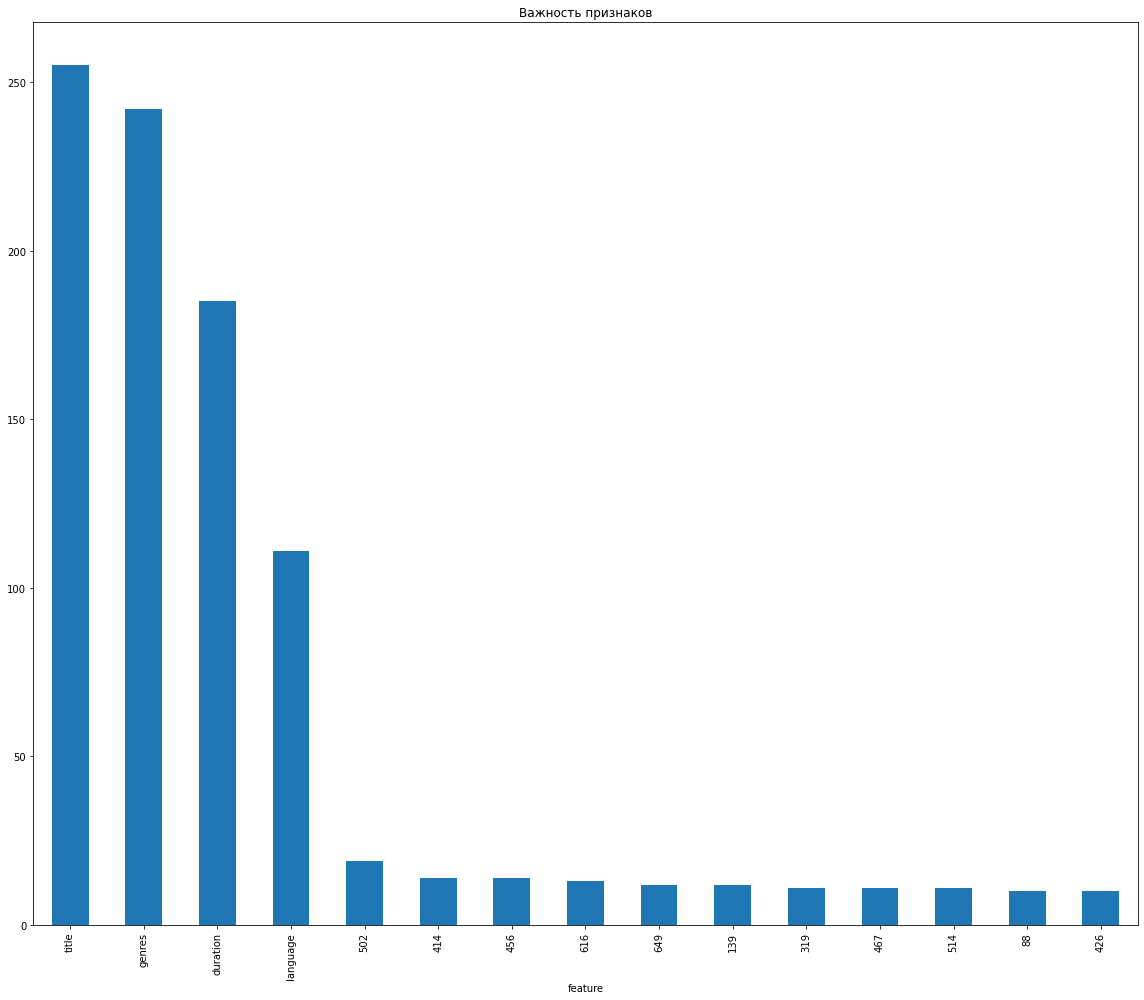

In [137]:
lgbm_imp = pd.Series(feature_importance, importance_df["feature"])

fig, ax = plt.subplots(figsize=(16, 14))
lgbm_imp \
    .sort_values(ascending=False) \
    .head(15).plot.bar(ax=ax)

ax.set_title("Важность признаков")
fig.tight_layout()

### Проверка лучшей модели на тестовой выборке

In [204]:
%%time

best_model = lgbm_model

y_pred_test = best_model.predict(X_test)
y_pred_proba_test = best_model.predict_proba(X_test)
acc_score = accuracy_score(y_test, y_pred_test)
roc_score = roc_auc_score(y_test, y_pred_proba_test[:,1])

print(f'ACCURACY: {acc_score:.2f}')
print(f' ROC AUC: {roc_score:.2f}')

ACCURACY: 0.94
 ROC AUC: 0.87
Wall time: 201 ms


In [205]:
get_conf_matrix(y_val, y_pred_test[:-1])

                Прогноз (+)  Прогноз (-)
Реальность (+)           51          909
Реальность (-)          814        12740


Оно переобучается(